In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.data import Dataset

In [2]:
train_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Train_Alphabet'
test_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Test_Alphabet'

In [3]:
train_path = train_path
test_path = test_path

for d in [train_path, test_path]:
    filepaths = []
    labels=[]
    classlist=sorted(os.listdir(d))
    
    for klass in classlist:        
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
            
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels') 
    
    if d == train_path:            
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
        
train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels']) 

print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)

print('The number of classes in the dataset is: ', class_count)

groups=train_df.groupby('labels')

print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist=[]
classlist=[]

for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]

print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)

for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
    
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  19440   test_df length:  2400   valid_df length:  2160
The number of classes in the dataset is:  24
            CLASS               IMAGE COUNT 
              A                     810     
              B                     810     
              C                     810     
              D                     810     
              E                     810     
              F                     810     
              G                     810     
              H                     810     
              I                     810     
              K                     810     
              L                     810     
              M                     810     
              N                     810     
              O                     810     
              P                     810     
              Q                     810     
              R                     810     
              S                     810     
              T            

In [4]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

In [5]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize = (20, 20))
    length = len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [6]:
max_samples=150 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=150
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  150  and the minimum samples in any class is  150


In [7]:
working_dir=r'./'
img_size = (128, 128)
batch_size = 30

trgen = ImageDataGenerator(horizontal_flip=True,rotation_range=25, width_shift_range=.25,
                            height_shift_range=.3, zoom_range=.4,  brightness_range=[0.35, 1.65])
t_and_v_gen = ImageDataGenerator()

msg = '{0:70s} for train generator'.format(' ')
print(msg, '\r', end = '') # prints over on the same line

train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

msg = '{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps = int(length/test_batch_size)

msg = '{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# from the generator we can get information we will need later
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3600 validated image filenames belonging to 24 classes.          for train generator 
Found 2160 validated image filenames belonging to 24 classes.          for valid generator 
Found 2400 validated image filenames belonging to 24 classes.          for test generator 
test batch size:  80   test steps:  30  number of classes :  24


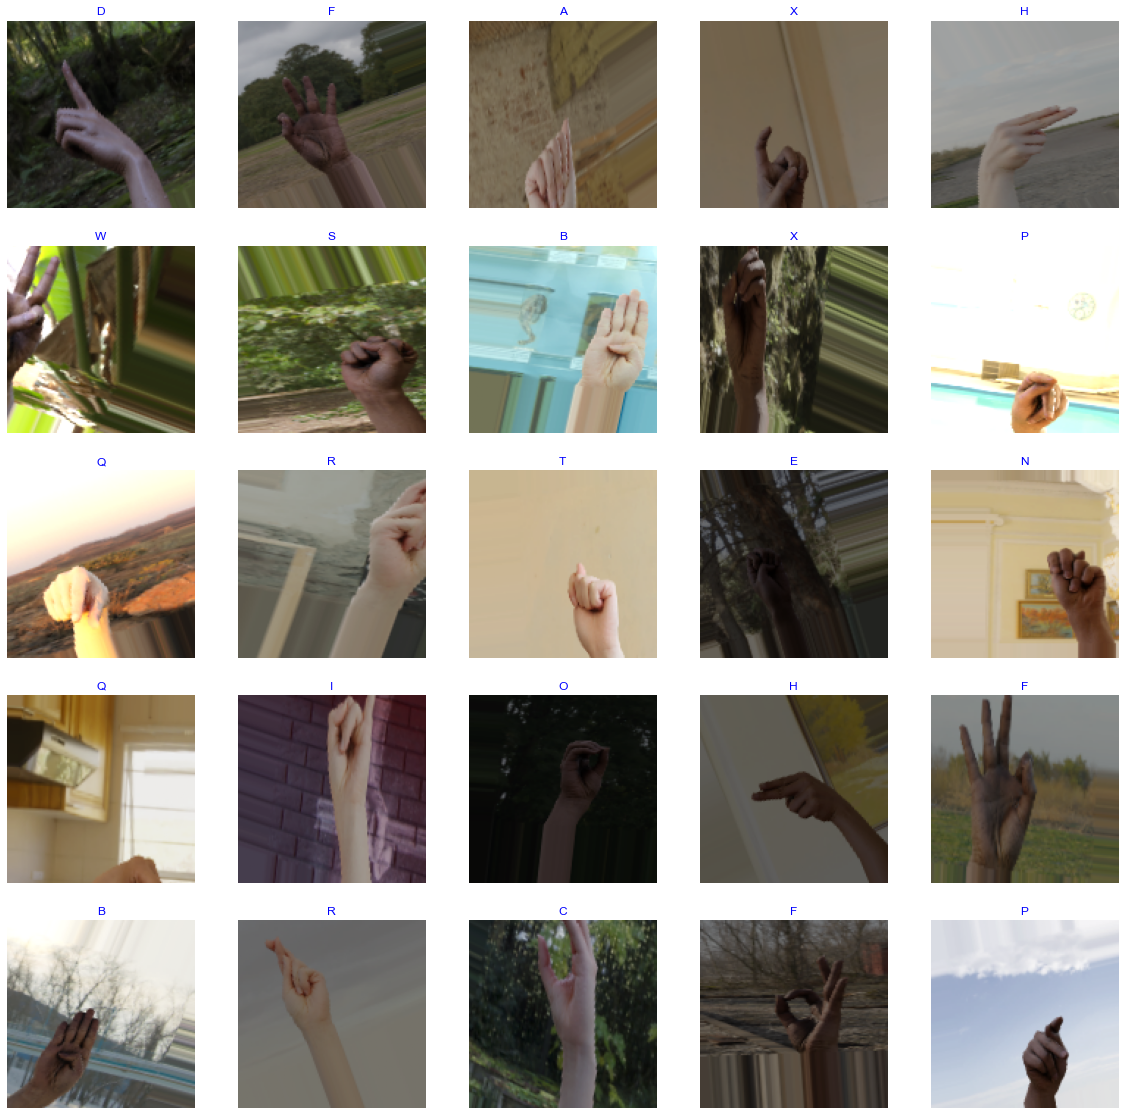

In [8]:
show_image_samples(train_gen)

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [10]:
img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, input_shape=img_shape, pooling='max')
base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

lr=.005
model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [13]:

model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, input_shape=img_shape, pooling='max')
subject = 'EfficientNetB3' 

save_id = subject + '.h5' 
model_save_loc = os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  ./EfficientNetB3.h5


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 128, 128, 3)  0           ['normalization[0][0]']      

 ivation)                                                                                         
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 65, 65, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 32, 32, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 32, 32, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block2c_activation (Activation  (None, 32, 32, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
          

 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 16, 16, 288)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 16, 16, 48)   13824       ['block3b_se_excite[0][0]']      
          

 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 8, 8, 288)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 8, 8, 96)     27648       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 8, 8, 96)    384         ['block4a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 8, 8, 96)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 8, 8, 96)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 8, 8, 576)    55296       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 8, 8, 576)   2304        ['block4d_expand_conv[0][0]']    
 ization) 

                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 8, 8, 576)    55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 8, 8, 576)   2304        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 8, 8, 576)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_d

 block5c_dwconv (DepthwiseConv2  (None, 8, 8, 816)   20400       ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 8, 8, 816)   3264        ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 8, 8, 816)   0           ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 816)         0           ['block5c_activation[0][0]']     
 agePoolin

                                                                                                  
 block5e_activation (Activation  (None, 8, 8, 816)   0           ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 34)     27778       ['block5e_se_reshape[0][0]']     
          

 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 4, 4, 1392)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 4, 4, 232)    322944      ['block6b_se_excite[0][0]']      
          

                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 232)    322944      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 232)   928         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 4, 4, 232)    0           ['block6d_project_bn[0][0]']     
          

                                                                                                  
 block6f_project_bn (BatchNorma  (None, 4, 4, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 4, 4, 232)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 4, 4, 232)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 4, 4, 1392)   322944      ['block6f_add[0][0]']            
          

                                                                                                  
 top_bn (BatchNormalization)    (None, 4, 4, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 4, 4, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 max_pool (GlobalMaxPooling2D)  (None, 1536)         0           ['top_activation[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 1536)        6144        ['max_pool[0][0]']               
 alization)                                                                                       
                                                                                                  
 dense (De

In [40]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print ('\n validation loss reduced, saving weights from epoch ', epoch + 1, ' as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print('current LR is ', lr,'  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print ('keeping current LR')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [41]:
epochs = 100
ask_epoch = 40
ask = LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks = [ask]

In [ ]:
history = model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
120/120 [==============================] - ETA: 0s - loss: 9.5103 - accuracy: 0.1694 
 validation loss reduced, saving weights from epoch  1  as best weights
120/120 [==============================] - 2526s 19s/step - loss: 9.5103 - accuracy: 0.1694 - val_loss: 48.3991 - val_accuracy: 0.2255
Epoch 2/40
 24/120 [=====>........................] - ETA: 17:06 - loss: 5.4472 - accuracy: 0.4153

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [ ]:
subject = 'metoda0_EfficientNetB3' 
acc = str(( 1-errors/tests) * 100)
index = acc.rfind('.')
acc = acc[:index + 3]
save_id = subject + '_' + str(acc) + '.h5' 
model_save_loc = os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 